In [11]:
# External libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score

How each feature contributes

Class distribution:
 Class
1    115
0     56
Name: count, dtype: int64 


Top features by combined importance:

       Feature  RandomForest  Lasso  MutualInfo   MeanRank
0      MDEC-23      0.093442    0.0    0.055426   3.666667
6   SpMin1_Bhs      0.099228    0.0    0.020523   4.333333
9       GATS8s      0.090084    0.0    0.031612   4.333333
4    CrippenMR      0.079456    0.0    0.067962   4.666667
10  SpMax5_Bhv      0.076365    0.0    0.022502   6.666667
1       MATS2v      0.076480    0.0    0.014437   7.333333
12       VPC-4      0.083437    0.0    0.000000   7.500000
8       GATS8e      0.079667    0.0    0.000000   7.833333
2       ATSC8s      0.075310    0.0    0.009580   8.333333
11     VE3_Dzi      0.079131    0.0    0.000000   8.500000
7        C1SP2      0.034525    0.0    0.016993   8.666667
5   SpMax7_Bhe      0.074177    0.0    0.008727   9.000000
3       VE3_Dt      0.058697    0.0    0.000000  10.166667


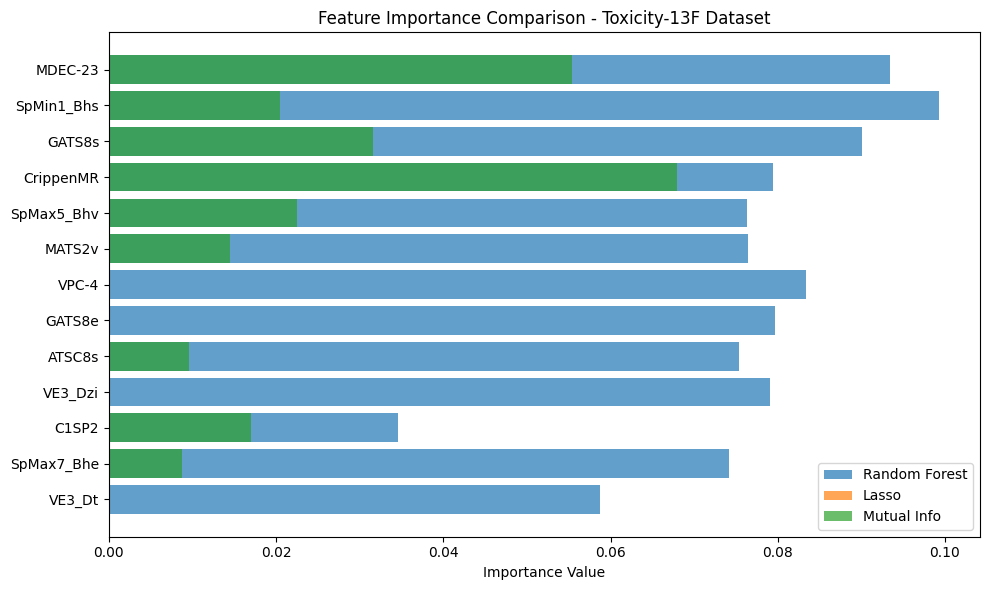

In [6]:
# --- Load dataset ---
dataset_save = "Dataset/Toxicity-13F.csv"
df = pd.read_csv(dataset_save)
df['Class'] = df['Class'].apply(lambda v: 1 if str(v).strip().lower().startswith('non') else 0)

# Quick look at target balance
print("Class distribution:\n", df['Class'].value_counts(), "\n")

# --- Separate features and target ---
X = df.drop(columns=['Class'])
y = df['Class']

# --- Split the data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# --- Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Random Forest Importance ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
rf_importances = rf.feature_importances_

# --- Lasso Importance ---
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)
lasso_importances = np.abs(lasso.coef_)

# --- Mutual Information ---
mi_importances = mutual_info_classif(X_train_scaled, y_train, random_state=42)

# --- Combine all importances ---
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'RandomForest': rf_importances,
    'Lasso': lasso_importances,
    'MutualInfo': mi_importances
})

# --- Rank and aggregate ---
importance_df['MeanRank'] = (
    importance_df[['RandomForest', 'Lasso', 'MutualInfo']]
    .rank(ascending=False)
    .mean(axis=1)
)
importance_df = importance_df.sort_values('MeanRank')

# --- Display ---
print("\nTop features by combined importance:\n")
print(importance_df)

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['RandomForest'], label='Random Forest', alpha=0.7)
plt.barh(importance_df['Feature'], importance_df['Lasso'], label='Lasso', alpha=0.7)
plt.barh(importance_df['Feature'], importance_df['MutualInfo'], label='Mutual Info', alpha=0.7)
plt.gca().invert_yaxis()
plt.legend()
plt.title("Feature Importance Comparison - Toxicity-13F Dataset")
plt.xlabel("Importance Value")
plt.tight_layout()
plt.show()


How many features should be kept

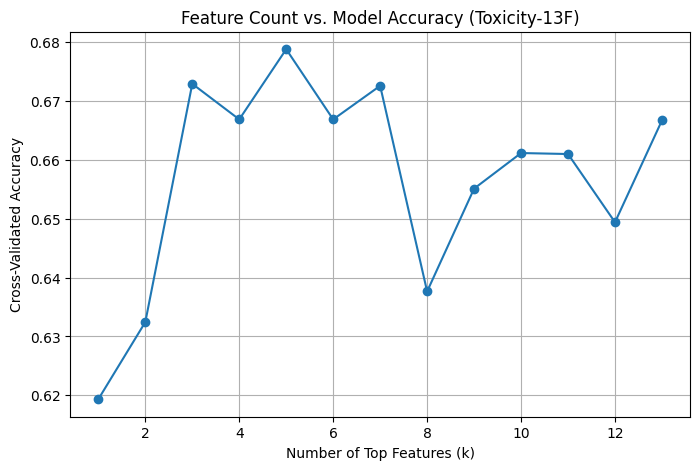

Best number of features: 5
Best CV accuracy: 0.679

Top features at best_k:
 ['MDEC-23', 'SpMin1_Bhs', 'GATS8s', 'CrippenMR', 'SpMax5_Bhv']


In [12]:
# Sort features by importance
ranked_features = importance_df.sort_values("MeanRank")["Feature"].tolist()

# --- Evaluate performance as we add more features ---
cv_scores = []
k_values = range(1, len(ranked_features) + 1)

for k in k_values:
    selected = ranked_features[:k]
    X_subset = df[selected]
    y = df["Class"]
    
    # Same scaling as before
    X_scaled = StandardScaler().fit_transform(X_subset)
    
    # 5-fold CV accuracy using RandomForest
    rf = RandomForestClassifier(random_state=42)
    scores = cross_val_score(rf, X_scaled, y, cv=5, scoring="accuracy")
    cv_scores.append(scores.mean())

# --- Plot results ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("Number of Top Features (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Feature Count vs. Model Accuracy (Toxicity-13F)")
plt.grid(True)
plt.show()

# --- Identify best k ---
best_k = k_values[np.argmax(cv_scores)]
best_acc = np.max(cv_scores)
print(f"Best number of features: {best_k}")
print(f"Best CV accuracy: {best_acc:.3f}")
print("\nTop features at best_k:\n", ranked_features[:best_k])


Reduce dataset to only relevant features

In [10]:
top5_features = ['MDEC-23', 'SpMin1_Bhs', 'GATS8s', 'CrippenMR', 'SpMax5_Bhv']
df_top5 = df[top5_features + ['Class']]

# Save the reduced dataset
reduced_path = "Dataset/Toxicity-Top5.csv"
df_top5.to_csv(reduced_path, index=False)

print(f"✅ Reduced dataset saved to: {reduced_path}")
print("\nNew dataset shape:", df_top5.shape)
print("\nPreview:")
print(df_top5.head())

✅ Reduced dataset saved to: Dataset/Toxicity-Top5.csv

New dataset shape: (171, 6)

Preview:
   MDEC-23  SpMin1_Bhs  GATS8s  CrippenMR  SpMax5_Bhv  Class
0  60.1757      2.3109  1.0575     0.0000      3.5545      1
1  44.5031      2.1117  1.7013   172.2000      3.6066      1
2  37.5488      2.0198  0.7828   173.4028      3.6441      1
3  40.5929      2.0191  1.0298   177.2726      3.6564      1
4  52.7343      2.1664  0.7427   171.1315      3.5216      1
